In [1]:
import clip
import torch

In [2]:

# one of clip.available.models()
# currently: ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']
# model_type = 'RN50'
# model_type = 'RN101'
# model_type = 'RN50x4'
# model_type = 'RN50x16'
model_type = 'ViT-B/16'
# model_type = 'ViT-B/32'

model, preprocess = clip.load(model_type)

100%|███████████████████████████████████████| 335M/335M [01:14<00:00, 4.74MiB/s]


In [3]:
template = 'a photo of a {}.'

flowers = [ 
    'daisy',
    'dandileon',
    'rose',
    'sunflower',
    'tulip'
]

In [4]:
text_tokens = clip.tokenize([ template.format(flower) for flower in flowers ])

with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()

text_features /= text_features.norm(dim=-1, keepdim=True)

In [5]:
import os
from os import walk
BASE = '../../data/tensorflow_flowers'

files = []

for (dirpath, _, filenames) in walk(BASE):
    f = [os.path.join(dirpath, i) for i in filenames]
    files.extend(f)

In [6]:
from PIL import Image
import numpy as np

orig_imgs = []
processed_imgs = []

# read image
for ff in files:

    img = Image.open(ff).convert("RGB")
    
    orig_imgs.append(img)

    # preprocess
    processed_imgs.append(preprocess(img))

# stack
image_stack = torch.tensor(np.stack(processed_imgs))

# call ML
with torch.no_grad():
    image_features = model.encode_image(image_stack).float()

image_features /= image_features.norm(dim=-1, keepdim=True)

In [7]:
scores = (image_features @ text_features.T).softmax(dim=-1)
top_scores, top_labels = scores.cpu().topk(len(flowers), dim=-1)

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

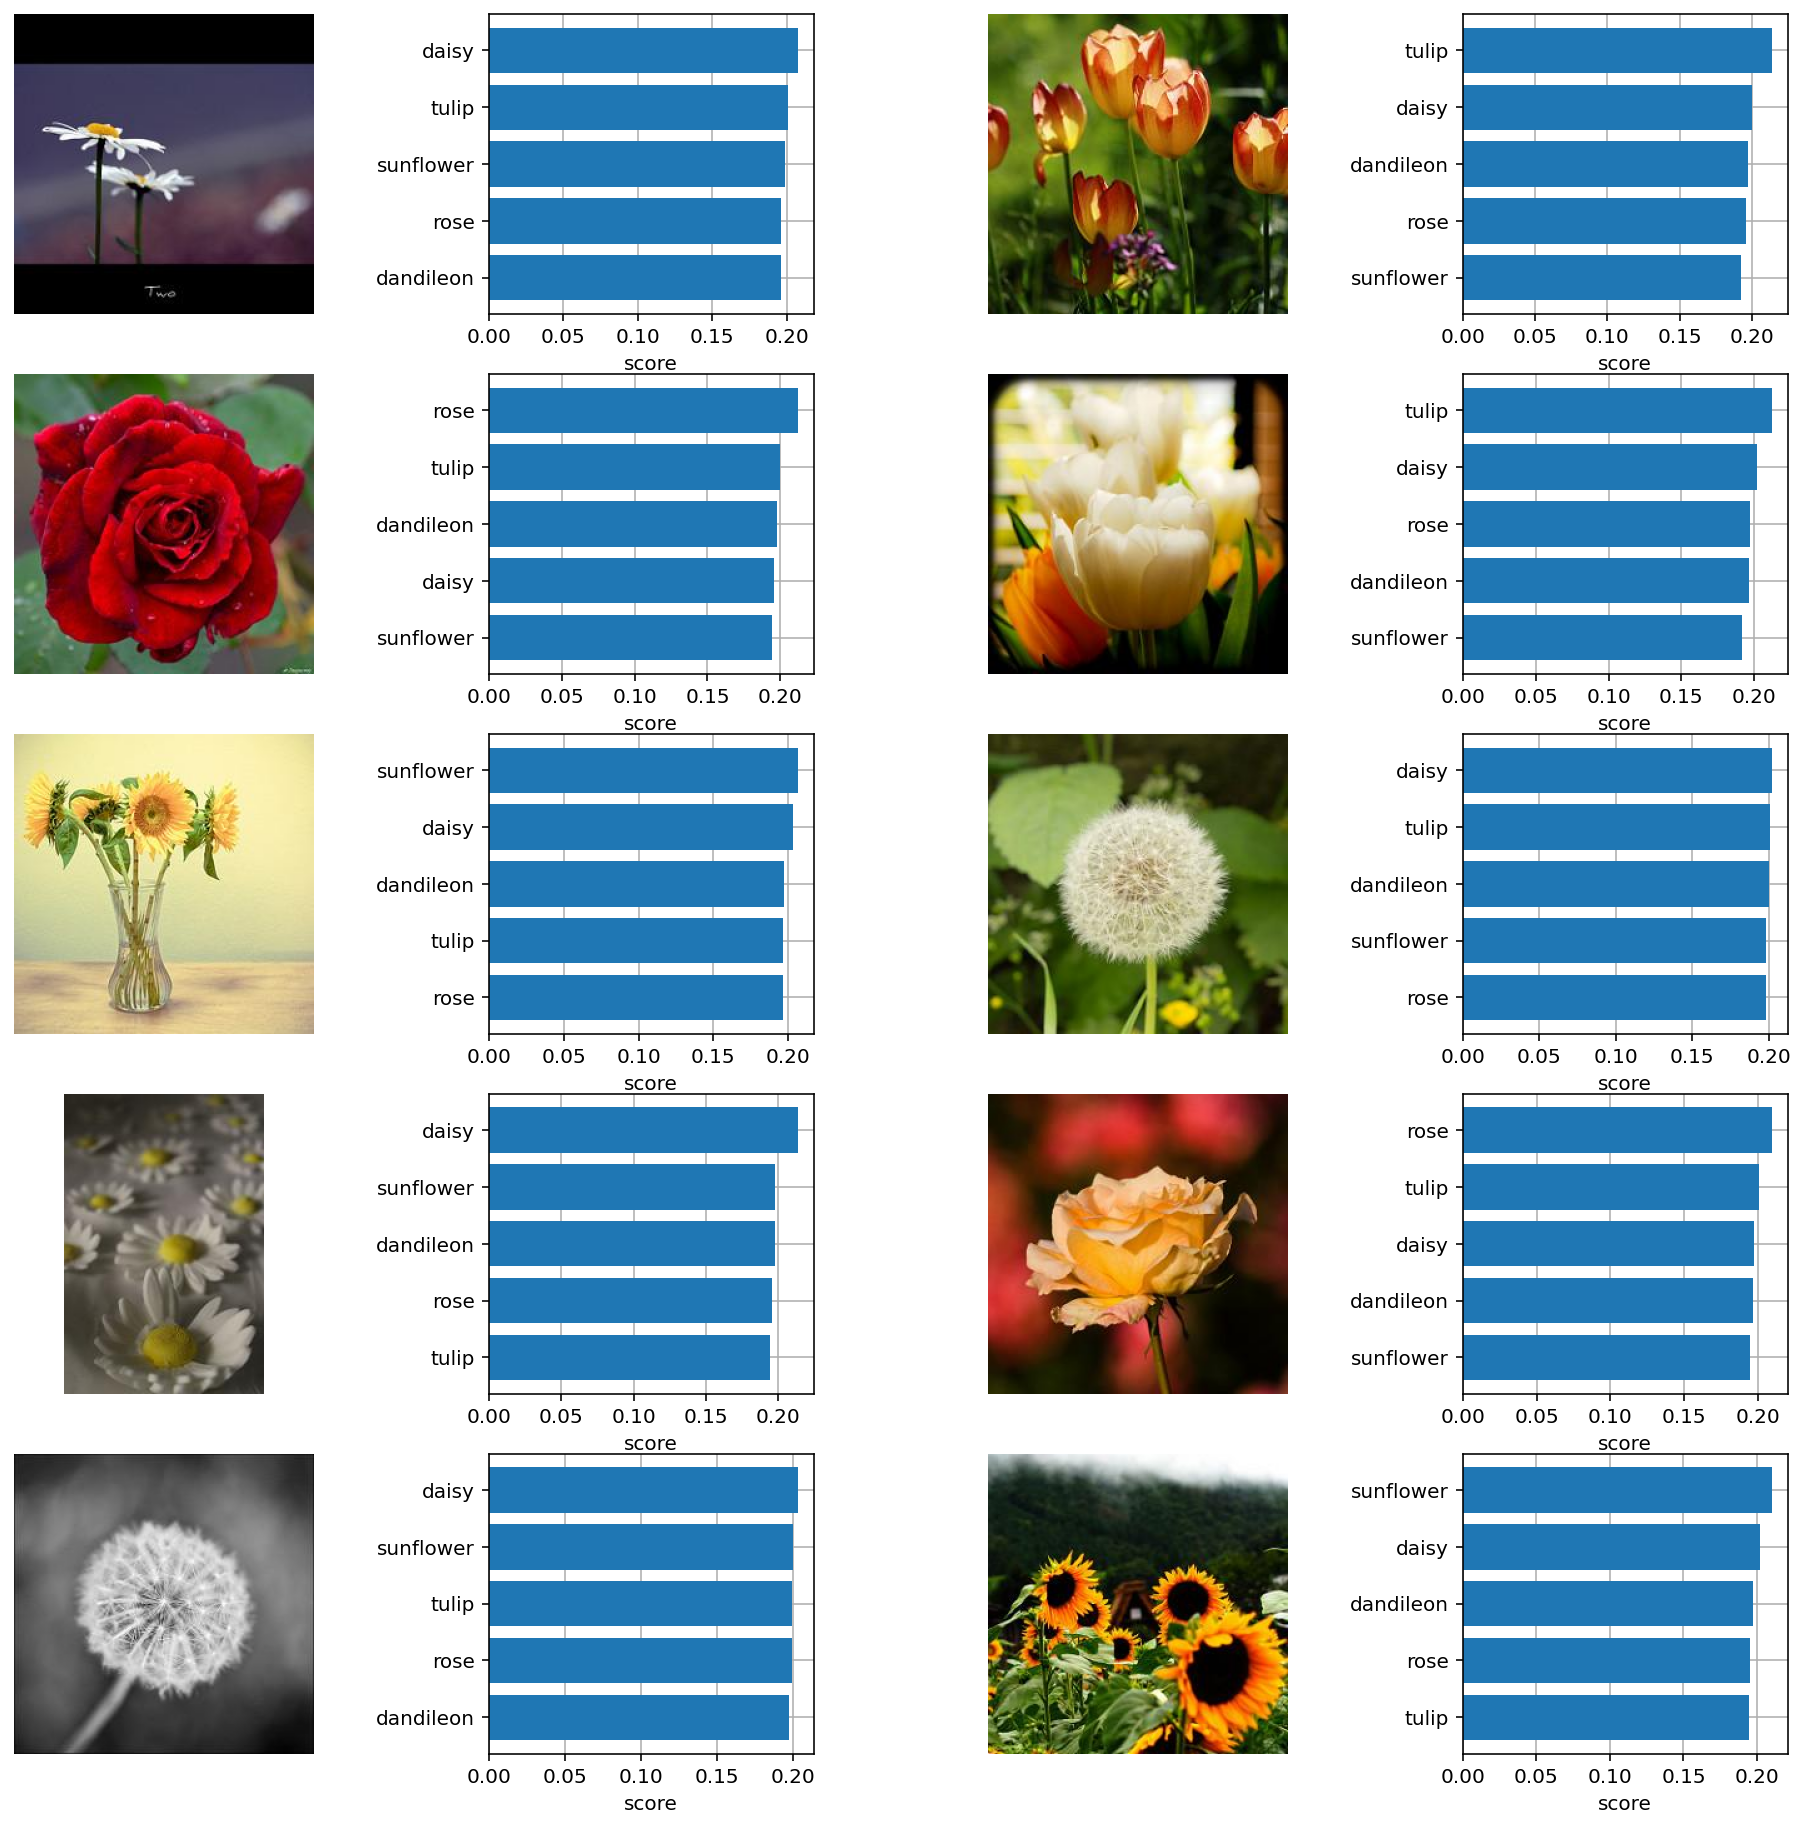

In [9]:
plt.figure(figsize=(16, 16))


for i, image in enumerate(orig_imgs):
    plt.subplot(len(orig_imgs)//2, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(len(orig_imgs)//2, 4, 2 * i + 2)

    y = np.arange(top_scores[i].shape[-1])
    plt.grid()
    plt.barh(y, top_scores[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [flowers[j] for j in top_labels[i].numpy()])
    plt.xlabel("score")

plt.subplots_adjust(wspace=0.5)